In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import os
import pandas as pd
import xlrd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import requests
import json
import math
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Creates a list of municipalities to extract data from map.

In [269]:
def municipios_func():
    
    # Read CSV file which contains all Puerto Rico municipalities.
    municipios = pd.read_csv('/Users/samielzengotita/Documents/IRONHACK/PROYECT/Real_Estate/PR_Municipios')
    
    # Convert municipalities to a list.
    municipios = municipios.values.tolist()
    
    # Make each municipality a unique value in the list(flatten).
    flat_list = []
    for row in municipios:
        flat_list.extend(row)
        
    # Removed Moca, since Moca is not listed in the map where we'll extract data.
    flat_list.remove('Moca')
    
    # Added ', PR' to each municipality, since the map requires the name of the municipality and PR letters.
    muni_pr = []
    for municipio in flat_list:
        muni_pr.append(municipio + ', PR')
    return muni_pr

# Webscraping - Gathering data from map website

In [270]:
def download_data(municipio):
    # This function takes as parameter the municipio, which can be 1 or a list.
    
    # Firs line selects the search field to input the municipio name.
    site_input = driver.find_element(By.CSS_SELECTOR,'#searchField')
    site_input.clear()
    
    # Input municipio in search field.
    site_input.send_keys(municipio)
    button = driver.find_element(By.CSS_SELECTOR,'#searchButton')
    button.click()
    time.sleep(2)
    
    # Since we only want CDBG data, we create a while loop to only download files that contain the text CDBG.
    i = 1
    while True:
        cdbg = driver.find_element(By.CSS_SELECTOR,f'#listOfGranteesFound > option:nth-child({i})')
        if 'CDBG' not in cdbg.text:
            i+=1
            time.sleep(2)
        else:
            break
            
    # Clicks the item that contains the letters CDBG.
    cdbg.click()
    finish = driver.find_element(By.CSS_SELECTOR,'#idChooseGranteeFinishBtn')
    
    # Clicks finish button.
    finish.click()
    time.sleep(2)
    export = driver.find_element(By.CSS_SELECTOR,'#exportBtn')
    
    # Finally clicks export button to download file. 
    export.click()
    

NOTE: After downloading excel files from map, from 78 municipalities in Puerto Rico, only 26 had unique values. This sorting was done manually. Also, there was no apparent pattern to rename each file to the selected municipality, therefore file renaming to selected municipality was also done manually. 

This is an important step, since in the next function the program will extract the name of each file to use it as key in a dictionary. To retrieve the values for each key, you only have to input the municipality name.

# Cleans excel files to create the first dataframe, which is CDBG data.

In [271]:
def clean_excel_df1(file):
    # This function takes as parameter the directory of the file it will clean.
    
    # The downloaded data from the map have the same pattern inside the file.
    # First we skip the unnecessary rows.
    df_excel_1 = pd.read_excel((file), skiprows=[0,1,2,3,4,5,6,7])
    
    # A column is name Nan, and .rename function doesn't work. We have to convert it to another string.
    df_excel_1.columns = df_excel_1.columns.fillna('type')
    
    # Rename each column to it's respective year.
    df_excel_1.rename(columns={"type": "2018"}, inplace=True)
    df_excel_1.rename(columns={"nan.1": "2019"}, inplace=True)
    df_excel_1.rename(columns={"nan.2": "2020"}, inplace=True)
    df_excel_1.rename(columns={"nan.3": "2021"}, inplace=True)
    
    # Drop empty columns.
    df_excel_1 = df_excel_1.drop('Unnamed: 1', axis=1)
    df_excel_1 = df_excel_1.drop('Unnamed: 2', axis=1)
    
    # Only returns the row that we want. 
    cleaned_excel_cdbg = df_excel_1.iloc[:1,:]
    
    return cleaned_excel_cdbg

# Gives a dictionary with 26 datasets for each municipality, with CDBG data

In [340]:
melted_cdbg = []
def cdbg_data(directory):
    # This functions takes in as parameter the directory where the files are stored.
    dirname = directory
    
    
    # For each file, extract the municipality name and then apply clean_excel_df1 function.
    for file in os.scandir(dirname):
        if file.path.endswith('.xlsx'):
            municipality_name = os.path.splitext(file.name)[0]
            # Create a dataframe from the values returned after applying clean_excel_df1 function.
            df = clean_excel_df1(file)
            
            # Add a 'Municipality' column to the DataFrame.
            df['Municipality'] = municipality_name
            
            # Melts municipalities names and values to create a new dataframe wich Municipalities as 
            # index, year as columns and the values are the CDBG amount given to each municipality for
            # each year.
            melted_cdbg.append(df.melt(id_vars=['Municipality'], var_name='Year', value_name='CDBG_Amount'))
    
    return melted_cdbg

# Cleans excel files to create the second dataframe, which is the grantee data.

In [273]:
def clean_excel_df2(file):
    # This function takes as parameter the directory of the file it will clean.
    
    # The downloaded data from the map have the same pattern inside the file.
    # First we skip the unnecessary rows.
    df_excel_2 = pd.read_excel((file), skiprows=[0,1,2,3,4,5,6,7])
    
        
    # A column is name Nan, and .rename function doesn't work. We have to convert it to another string.
    df_excel_2.columns = df_excel_2.columns.fillna('type')
    
    # Rename each column to it's respective year.
    df_excel_2.rename(columns={"type": "2018"}, inplace=True)
    df_excel_2.rename(columns={"nan.1": "2019"}, inplace=True)
    df_excel_2.rename(columns={"nan.2": "2020"}, inplace=True)
    df_excel_2.rename(columns={"nan.3": "2021"}, inplace=True)
    
    # Drop empty columns.
    df_excel_2 = df_excel_2.drop('Unnamed: 1', axis=1)
    df_excel_2 = df_excel_2.drop('Unnamed: 2', axis=1)
    
     # Only returns the row that we want. 
    df_excel_2 = df_excel_2.loc[7:28,:]
    cleaned_excel_grantee = df_excel_2
    
    # We reset the index for it to start at 0.
    cleaned_excel_grantee.reset_index(drop=True, inplace=True)
    
    # We drop the columns we don't need.
    cleaned_excel_grantee = df_excel_2.drop("2018", axis=1,inplace=True)
    cleaned_excel_grantee = df_excel_2.drop('2019', axis=1,inplace=True)
    cleaned_excel_grantee = df_excel_2.drop('2020', axis=1,inplace=True)
    cleaned_excel_grantee = df_excel_2.drop('2021', axis=1,inplace=True)
    
    # We drop the rows we don't need.
    cleaned_excel_grantee = df_excel_2.drop([df_excel_2.index[4], df_excel_2.index[5], df_excel_2.index[11], df_excel_2.index[12], df_excel_2.index[13], df_excel_2.index[14], df_excel_2.index[15]])
    
    # We reset index again.
    cleaned_excel_grantee.reset_index(drop=True, inplace=True)
    
    # We rename column 2022 to Amounnt.
    cleaned_excel_grantee.rename(columns={2022: "Amount"}, inplace=True)
    
    # It returns a dataframe with index starting at 0, a column with a description and amount for each description.
    return cleaned_excel_grantee

# Gives a dictionary with 26 datasets for each municipality, with grantee data

In [274]:
grant_dict = {}
def grant_data(directory):
    # This functions takes in as parameter the directory where the files are stored.
    
    dirname = directory
    
    # For each file, extract the municipality name and then apply clean_excel_df1 function.
    for file in os.scandir(dirname):
        if file.path.endswith('.xlsx'):
            municipality_name = os.path.splitext(file.name)[0] 
            
            # Apply clean_excel_df2.
            df_grant_data = clean_excel_df2(file)
            
            # Creates a dictionary with municipality names as keys and the values returned from
            # clean_excel_df2 as values.
            grant_dict[municipality_name] = df_grant_data

# Returns a list where you can copy the municipality to call upon any of the 26 datasets created, if needed.

In [275]:
def muni_copy():
    # This function is to facilitate access to the dictionary returned in grant_data() function.
    # It returns the list of the municipalities as written in the dictionary, for easy indexing.
    
    muni_copy_list = []
    for key,value in df_dict.items():
        muni_copy.append(key)
    muni_copy_list

# Webscraping - Gathers mortgage data.

In [276]:
def get_fha_snapshots():
    # This function gathers mortgage data. 
    
    # If the user wants data from 2023, the input is 3.
    # If the user wants data from 2022, the input is 2.
    # If the user wants data from 2018-2021, the input is 7.
    # There is no input validation, MAKE SURE TO INPUT JUST THE NUMBER.
    
    # Since the website groups data by year, each number will represent what button the program has to click.
    i = input('2023 Data: 3 | 2022 Data: 5 | 2018-2021: 7:' )
    i = int(i)
    if i == 5:
        for j in range(1,13):
            site_input = driver.find_element(By.CSS_SELECTOR,f'#block-system-main > div > div:nth-child(1) > div > div > div > div > div > div > div > div > div.genlink > ul:nth-child({i}) > li:nth-child({j}) > a')
            site_input.click()
            time.sleep(2)
            
    elif i ==7:
        for j in range(1,49):
            site_input = driver.find_element(By.CSS_SELECTOR,f'#block-system-main > div > div:nth-child(1) > div > div > div > div > div > div > div > div > div.genlink > ul:nth-child({i}) > li:nth-child({j}) > a')
            site_input.click()
            time.sleep(2)
    elif i == 3:
        for j in range(1,13):
            site_input = driver.find_element(By.CSS_SELECTOR,f'#block-system-main > div > div:nth-child(1) > div > div > div > div > div > div > div > div > div.genlink > ul:nth-child({i}) > li:nth-child({j}) > a')
            site_input.click()
            time.sleep(2)

# Cleans names of mortgage data excel files.

In [277]:

def rename_fha_snapshots(directory):
    # This functions takes in as parameter the directory where the files are stored.
    
    
    dirname = directory
    
    # It basically rename the files downloaded from get_fha_snapshots() functions, based
    # on multiple patters found in the name of the files. This will help us in the future
    # to access mortgage data by year.
    
    for file in os.scandir(dirname):
        if file.name.startswith('FHA_SFSnapshot_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHA_SFSnapshot_','')}")
            
    for file in os.scandir(dirname):
        if file.name.startswith('FHA_SFSnapshot Forward_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHA_SFSnapshot Forward_','')}")
            
    for file in os.scandir(dirname):
        if file.name.startswith('FHA_SFSnapshotForward_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHA_SFSnapshotForward_','')}")
            
    for file in os.scandir(dirname):
        if file.name.startswith('FHA_Snapshot_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHA_Snapshot_','')}")
            
    for file in os.scandir(dirname):
        if file.name.startswith('FHASFSnapshotForward_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHASFSnapshotForward_','')}")
            
    for file in os.scandir(dirname):
        if file.name.startswith('FHASFSnapshot_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHASFSnapshot_','')}")
    
    for file in os.scandir(dirname):
        if file.name.endswith('_New.xlsx'):
            os.rename(f'{file.path}', f"{file.path.replace('_New','')}")
    
    for file in os.scandir(dirname):
        if file.name.endswith('..xlsx'):
            os.rename(f'{file.path}', f"{file.path.replace('..xlsx','.xlsx')}")
            
    for file in os.scandir(dirname):
        if file.name.endswith('T.xlsx'):
            os.rename(f'{file.path}', f"{file.path.replace('T.xlsx','.xlsx')}")
            
    for file in os.scandir(dirname):
        if file.name.startswith('FHA_SFSnapshot2Forward_'):
            os.rename(f'{file.path}', f"{file.path.replace('FHA_SFSnapshot2Forward_','')}")
    
    for file in os.scandir(dirname):
        if file.name.startswith('Forward_'):
            os.rename(f'{file.path}', f"{file.path.replace('Forward_','')}")

# Returns interest rate average for each year (2018-2022) and average for mortgage amount.

In [278]:
interest_rate_avg = {}
original_mortgage_amount_avg = {}

def mortgage_avg(directory):
    # This functions takes in as parameter the directory where the files are stored.
    
    # The purpose of this function is to extract mortgage data from the USA.
    directory_path = directory
    
    
    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".xlsx"):  
            
            # For each file, use the index method to find the year it represents.
            year = filename[-9:-5]
            
            # Only access the third sheet in each excel file, which in indexing it would be 2.
            df = pd.read_excel(os.path.join(directory_path, filename), sheet_name=2)  
            
            # Convert Interest Rate column to numbers and ignore any errors.
            df['Interest Rate'] = pd.to_numeric(df['Interest Rate'], errors='coerce')
            
            # Convert Original Mortgage Amount column to numeric and ignore any errors.
            df['Original Mortgage Amount'] = pd.to_numeric(df['Original Mortgage Amount'], errors='coerce')
            
            # Ignore the first row, since it's not numeric and will cause errors when making calculations.
            df = df.iloc[1:]
            
            # If the year is not in the dictionary, it will make the calculations, which is the average
            # Interest Rate of each year.
            if year not in interest_rate_avg:
                interest_rate_avg[year] = []
            interest_rate_avg[year].append(df['Interest Rate'].mean())
            
            # If the year is not in the dictionary, it will make the calculations, which is the average
            # Original Mortgage Amount of each year.
            if year not in original_mortgage_amount_avg:
                original_mortgage_amount_avg[year] = []
            original_mortgage_amount_avg[year].append(df['Original Mortgage Amount'].mean())
    
    # Sums the average of each year indivually, and then creates a dataframe with year and Average Interest Rate as columns.
    interest_rate_df = pd.DataFrame([(year, sum(avg_list) / len(avg_list)) for year, avg_list in interest_rate_avg.items()], columns=['Year', 'Interest Rate Average'])
    
    # Sums the average of each year indivually, and then creates a dataframe with year and Original Mortgage Amount as columns.
    original_mortgage_amount_df = pd.DataFrame([(year, sum(avg_list) / len(avg_list)) for year, avg_list in original_mortgage_amount_avg.items()], columns=['Year', 'Original Mortgage Amount Average'])
    
    
    print(interest_rate_df)
    print(original_mortgage_amount_df)

# Returns interest rate average for each year (2018-2022) and average for mortgage amount in Puerto Rico.

In [286]:
interest_rate_avg_pr = {}
original_mortgage_amount_avg_pr = {}
def mortgage_avg_pr(directory):
    # This functions takes in as parameter the directory where the files are stored.
    
    # The purpose of this function is to only extract mortgage data from Puerto Rico.
    directory_path = directory

    
    
    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".xlsx"):  
            
            # For each file, use the index method to find the year it represents.
            year = year = filename[-9:-5]
            
            # Only access the third sheet in each excel file, which in indexing it would be 2.
            df = pd.read_excel(os.path.join(directory_path, filename), sheet_name=2)
            
             # Convert Interest Rate column to numbers and ignore any errors.
            df['Interest Rate'] = pd.to_numeric(df['Interest Rate'], errors='coerce')
            
            # Convert Original Mortgage Amount column to numeric and ignore any errors.
            df['Original Mortgage Amount'] = pd.to_numeric(df['Original Mortgage Amount'], errors='coerce')
            
            # Ignore the first row, since it's not numeric and will cause errors when making calculations.
            df = df.iloc[1:]
            
            # Extract only the rows that contain the letters PR in the Property State Column.
            pr_rows = df[df['Property State'].str.contains("PR", na=False)]
            
            # Filter by pr_rows
            if not pr_rows.empty:
                
                # If the year is not in the dictionary, it will make the calculations, which is the average
                # Interest Rate of each year.
                if year not in interest_rate_avg_pr:
                    interest_rate_avg_pr[year] = []
                interest_rate_avg_pr[year].append(pr_rows['Interest Rate'].mean())
                
                # If the year is not in the dictionary, it will make the calculations, which is the average
                # Original Mortgage Amount of each year.
                if year not in original_mortgage_amount_avg_pr:
                    original_mortgage_amount_avg_pr[year] = []
                original_mortgage_amount_avg_pr[year].append(pr_rows['Original Mortgage Amount'].mean())
    
    # Sums the average of each year indivually, and then creates a dataframe with year and Average Interest Rate as columns.
    interest_rate_df_pr = pd.DataFrame([(year, sum(avg_list) / len(avg_list)) for year, avg_list in interest_rate_avg_pr.items()], columns=['Year', 'Interest Rate Average'])
    
    # Sums the average of each year indivually, and then creates a dataframe with year and Original Mortgage Amount as columns.
    original_mortgage_amount_df_pr = pd.DataFrame([(year, sum(avg_list) / len(avg_list)) for year, avg_list in original_mortgage_amount_avg_pr.items()], columns=['Year', 'Original Mortgage Amount Average'])
    
    
    print(interest_rate_df_pr)
    print(original_mortgage_amount_df_pr)
    

# Returns a list with the data (Income Limits) for each county in Puerto Rico for the selected year.

In [8]:
results = []
def api_request(year):
    # This function takes as parameter the year of the data you want to gather.
    
    base_url = 'https://www.huduser.gov/hudapi/public/il/data/'
    
    #loop to iterate through the FIPS codes
    # Only calls the 26 counties we will be working on.
    for key, value in cleaned_county_dict.items():
        url = f"{base_url}{value}?year={year}"
        result = requests.get(url,headers=headers)
        result = result.json()
        results.append(result)
    return results

# Returns a list with the data (Income Limits) for each county in Puerto Rico for 2023.

In [9]:
results_2023 = []
def api_request_2023():
    
    base_url = 'https://www.huduser.gov/hudapi/public/il/data/'
    
    #loop to iterate through the FIPS codes
    # Only calls the 26 counties we will be working on.
    for key, value in cleaned_dict.items():
        url = f"{base_url}{value}"
        result_2023 = requests.get(url,headers=headers)
        result_2023 = result.json()
        results_2023.append(result_2023)
    return results_2023

# RUNNING CODE

# Initialize Chrome manipulated by the program to gather CDBG data.

IMPORTANT: Add the directory (first line) where you want your files to download.

In [280]:
download_directory = ''
options = webdriver.ChromeOptions()
prefs = {
    "download.default_directory": f"{download_directory}",
    "download.directory_upgrade": True,
    "download.prompt_for_download": False,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(options=options)
driver.get('https://egis.hud.gov/cpdmaps/')
    
list(map(download_data, municipios_func()))

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=120.0.6099.109)
Stacktrace:
0   chromedriver                        0x0000000105fb8c48 chromedriver + 4852808
1   chromedriver                        0x0000000105fb01b3 chromedriver + 4817331
2   chromedriver                        0x0000000105b7c7bd chromedriver + 411581
3   chromedriver                        0x0000000105b502f8 chromedriver + 230136
4   chromedriver                        0x0000000105bfe41f chromedriver + 943135
5   chromedriver                        0x0000000105c15226 chromedriver + 1036838
6   chromedriver                        0x0000000105bf69a3 chromedriver + 911779
7   chromedriver                        0x0000000105bbe103 chromedriver + 680195
8   chromedriver                        0x0000000105bbf71e chromedriver + 685854
9   chromedriver                        0x0000000105f78792 chromedriver + 4589458
10  chromedriver                        0x0000000105f7d99c chromedriver + 4610460
11  chromedriver                        0x0000000105f5dcb1 chromedriver + 4480177
12  chromedriver                        0x0000000105f7e716 chromedriver + 4613910
13  chromedriver                        0x0000000105f4f23c chromedriver + 4420156
14  chromedriver                        0x0000000105f9e798 chromedriver + 4745112
15  chromedriver                        0x0000000105f9e94e chromedriver + 4745550
16  chromedriver                        0x0000000105fafdf3 chromedriver + 4816371
17  libsystem_pthread.dylib             0x00007ff80e87d202 _pthread_start + 99
18  libsystem_pthread.dylib             0x00007ff80e878bab thread_start + 15


# Run functions to return dataframes with CDBG data and Grantee Data.

In [341]:
cdbg_data(***directory where files were downloaded***)

[  Municipality        Year CDBG_Amount
 0     TOA_BAJA  Grant Name        CDBG
 1     TOA_BAJA        2018     1146503
 2     TOA_BAJA        2019     1082477
 3     TOA_BAJA        2020     1061237
 4     TOA_BAJA        2021     1050180
 5     TOA_BAJA        2022     1034426,
     Municipality        Year CDBG_Amount
 0  TRUJILLO_ALTO  Grant Name        CDBG
 1  TRUJILLO_ALTO        2018      828637
 2  TRUJILLO_ALTO        2019      811956
 3  TRUJILLO_ALTO        2020      834410
 4  TRUJILLO_ALTO        2021      835881
 5  TRUJILLO_ALTO        2022      774442,
   Municipality        Year CDBG_Amount
 0     CAROLINA  Grant Name        CDBG
 1     CAROLINA        2018     1866124
 2     CAROLINA        2019     1802252
 3     CAROLINA        2020     1753063
 4     CAROLINA        2021     1758787
 5     CAROLINA        2022     1757420,
   Municipality        Year CDBG_Amount
 0   JUANA_DIAZ  Grant Name        CDBG
 1   JUANA_DIAZ        2018      813888
 2   JUANA_DIAZ        

In [331]:
grant_data(***directory where files were downloaded***)

# Initialize Chrome manipulated by the program to gather mortgage data.

IMPORTANT: Add the directory (first line) where you want your files to download.

In [189]:
download_directory = ''
options = webdriver.ChromeOptions()
prefs = {
    "download.default_directory": f"{download_directory}",
    "download.directory_upgrade": True,
    "download.prompt_for_download": False,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(options=options)
driver.get('https://www.hud.gov/program_offices/housing/rmra/oe/rpts/sfsnap/sfsnap')
    


# Run functions to gather mortgage data, rename downloaded files and calculate the average interest rate and average mortgage amount.

In [ ]:
get_fha_snapshots()

In [ ]:
rename_fha_snapshots()

We used the mortgage_avg_pr function to gather 2023 data.

In [216]:
mortgage_avg_pr('/Users/samielzengotita/Documents/IRONHACK/PROYECT/Real_Estate/FHA SNAPSHOTS 2023')

   Year  Interest Rate Average
0  2023               6.196389
   Year  Original Mortgage Amount Average
0  2023                     140340.583901


We used the mortgage_avg_pr function to gather 2018-2022 data.

In [287]:
mortgage_avg_pr('/Users/samielzengotita/Documents/IRONHACK/PROYECT/Real_Estate/FHA SNAPSHOTS')

   Year  Interest Rate Average
0  2018               4.471869
1  2020               3.430573
2  2022               4.765068
3  2021               3.110612
4  2019               4.374230
   Year  Original Mortgage Amount Average
0  2018                     122444.482592
1  2020                     133942.448332
2  2022                     140124.195267
3  2021                     141794.494564
4  2019                     125793.622040


In [419]:
# Converted results from mortgage_avg_pr to dataframes.

interest_rate_df_pr = pd.DataFrame([(year, sum(avg_list) / len(avg_list)) for year, avg_list in interest_rate_avg_pr.items()], columns=['Year', 'Interest Rate Average'])
original_mortgage_amount_df_pr = pd.DataFrame([(year, sum(avg_list) / len(avg_list)) for year, avg_list in original_mortgage_amount_avg_pr.items()], columns=['Year', 'Original Mortgage Amount Average'])

# Sorted both dataframes by Year, starting by the oldest.
sorted_mortgage = original_mortgage_amount_df_pr.sort_values(by='Year')
sorted_interest = interest_rate_df_pr.sort_values(by='Year')

In [420]:
sorted_interest

,Year,Interest Rate Average
0,2018,4.471869
4,2019,4.374230
1,2020,3.430573
3,2021,3.110612
2,2022,4.765068


In [421]:
sorted_mortgage

,Year,Original Mortgage Amount Average
0,2018,122444.482592
4,2019,125793.622040
1,2020,133942.448332
3,2021,141794.494564
2,2022,140124.195267


In [422]:
# We merged sorted_interest and sorted_mortgage to only have 1 dataset.

merged_mortgage_data = pd.merge(sorted_interest, sorted_mortgage, on='Year')

# We set the years as index. 
merged_mortgage_data.set_index('Year', inplace=True)

merged_mortgage_data

,Interest Rate Average,Original Mortgage Amount Average
Year,,
2018,4.471869,122444.482592
2019,4.374230,125793.622040
2020,3.430573,133942.448332
2021,3.110612,141794.494564
2022,4.765068,140124.195267


In [424]:
# Combined results from cdbg data to create a dataset with municipality as index.
# The columns are Year and the values are the amount of CDBG given to each municipality in each year.

combined_cdbg = pd.concat(melted_cdbg, ignore_index=True)

pivot_cdbg = combined_cdbg.pivot_table(index='Municipality', columns='Year', values='CDBG_Amount', aggfunc='sum')

# Sorted Columns by year.
pivot_cdbg_concatenated = pivot_cdbg[["2018", "2019", "2020", "2021",2022]]

# Added a column that sums the total grant given to each municipality in the time period.
pivot_cdbg_concatenated['Total'] = pivot_cdbg_concatenated.sum(axis=1)

# Sorted dataframe by Total Amount Given.
pivot_cdbg_concatenated = pivot_cdbg_concatenated.sort_values(by='Total', ascending=False)

# Added a Row with the sum of the amount given in a year.
pivot_cdbg_concatenated.loc['Total'] = pivot_cdbg_concatenated.sum(axis=0)

# Changed municipality index to match API data.
# muni_analysis is a dictionary found at the bottom of the document.
pivot_cdbg_concatenated = pivot_cdbg_concatenated.rename(index=muni_analysis)

In [426]:
# Extracted the total amount given each year.
pivot_cdbg_total = pivot_cdbg_concatenated.iloc[-1].to_dict()

# To avoid value errors, we convert 2022 from number to a string.
pivot_cdbg_total['2022'] = pivot_cdbg_total[2022]
del pivot_cdbg_total['Total']
del pivot_cdbg_total[2022]
pivot_cdbg_total

{'2018': 32290384,
 '2019': 32065785,
 '2020': 32802299,
 '2021': 32453170,
 '2022': 31482724}

In [475]:
# We convert the dictionary pivot_cdbg_total to a dataset.

cdbg_total_df = pd.DataFrame(list(pivot_cdbg_total.items()), columns=['Year', 'CDBG Total'])

# We set year as index in the dataset.
cdbg_total_df.set_index('Year', inplace=True)

# We merge the cdbg_total_df dataset with merged_mortgage_data to visualize changes among years.
final_cdbg = pd.merge(merged_mortgage_data, cdbg_total_df, left_index=True, right_index=True, how='outer')

final_cdbg

,Interest Rate Average,Original Mortgage Amount Average,CDBG Total
Year,,,
2018,4.471869,122444.482592,32290384
2019,4.374230,125793.622040,32065785
2020,3.430573,133942.448332,32802299
2021,3.110612,141794.494564,32453170
2022,4.765068,140124.195267,31482724


In [476]:
# Extra step
# We add averages of 2023 to final_cdbg dataset.
# We drop CDBG Total column, since we don't have data for 2023.
interest_avg_2023 = 6.196389
mortgage_avg_2023 = 140340.583901
df2023 = final_cdbg
df2023.loc['2023'] = [6.196389, 140340.583901,0]
df2023 = df2023.drop('CDBG Total',axis = 1)
df2023

In [483]:
# We extract last two columns for visualization.
two_years = [4, 5]
df2023.iloc[two_years]

,Interest Rate Average,Original Mortgage Amount Average
Year,,
2022,4.765068,140124.195267
2023,6.196389,140340.583901


In [479]:
# We calculate percent change per year.
df2023_pct_change = df2023.pct_change() * 100
df2023_pct_change

,Interest Rate Average,Original Mortgage Amount Average
Year,,
2018,NaN,NaN
2019,-2.183415,2.735231
2020,-21.573087,6.477933
2021,-9.326774,5.862254
2022,53.187486,-1.177972
2023,30.037799,0.154426


In [436]:
# Calculate percent change from original dataset (which doesn't include year 2023)

interest_rate_pct_change = final_cdbg_percent_change = final_cdbg.pct_change() * 100
interest_rate_pct_change

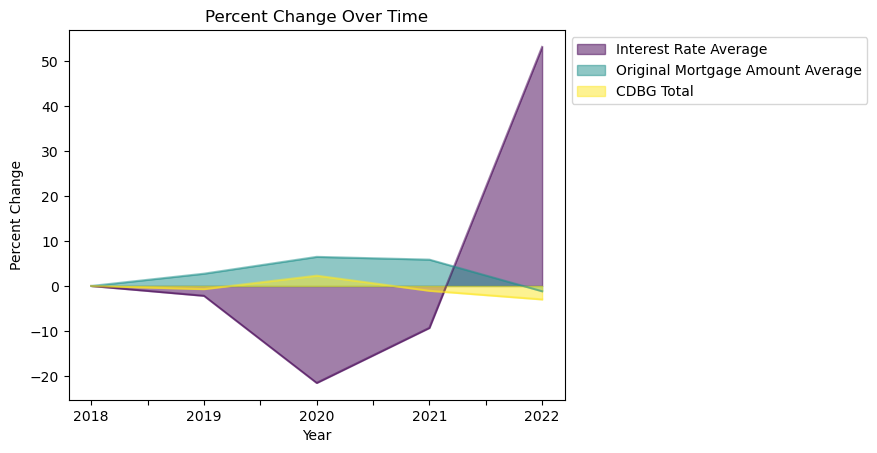

In [438]:
# Plot area chart with percent change
ax = interest_rate_pct_change.plot(kind='area', title='Percent Change Over Time', xlabel='Year', ylabel='Percent Change', stacked=False, colormap='viridis')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [429]:
# We created a new column to visualize the 2022 income limits and the CDBG funds assisgned to each county in 2022.
new_column_for_il_cdbg = pivot_cdbg_concatenated[2022]

pivot_table_il_cdbg = pd.merge(pivot_table_il, new_column_for_il_cdbg, left_index=True, right_index=True, how='left', suffixes=('', '_2022'))

# Rename new column
pivot_table_il_cdbg.rename(columns={'2022_2022': 'CDBG'}, inplace=True)

pivot_table_il_cdbg

,extremelylow_avg,low_avg,verylow_avg,2022
data.county_name,,,,
"Aguadilla Municipio, PR",8262.50,22050.00,13818.75,876284
"Arecibo Municipio, PR",8312.50,22162.50,13850.00,1342974
"Bayamón Municipio, PR",9806.25,26112.50,16318.75,2149057
"Cabo Rojo Municipio, PR",7862.50,20931.25,13087.50,840426
"Caguas Municipio, PR",10068.75,26775.00,16737.50,1706443
"Canóvanas Municipio, PR",9806.25,26112.50,16318.75,707339
"Carolina Municipio, PR",9806.25,26112.50,16318.75,1757420
"Cayey Municipio, PR",10068.75,26775.00,16737.50,603629
"Cidra Municipio, PR",10068.75,26775.00,16737.50,575730


In [430]:
# We sort table by CDBG amount.
pivot_table_il_cdbg.rename(columns={2022: 'CDBG'}, inplace=True)
pivot_table_sorted = pivot_table_il_cdbg.sort_values(by='CDBG', ascending=False)

# We extract the first 5 values and then drop extremelylow_avg and verylow_avg to only visualize
# low_avg with CDBG data.
pivot_table_sorted = pivot_table_sorted.head()
pivot_table_sorted.drop(['extremelylow_avg'],axis=1,inplace=True)
pivot_table_sorted.drop(['verylow_avg'],axis=1,inplace = True)
pivot_table_sorted

,low_avg,CDBG
data.county_name,,
"San Juan Municipio, PR",26112.50,6969795
"Ponce Municipio, PR",21743.75,2351583
"Bayamón Municipio, PR",26112.50,2149057
"Carolina Municipio, PR",26112.50,1757420
"Caguas Municipio, PR",26775.00,1706443


In [434]:
# We calculate the average for the column low_avg
average_income_limit_2022 = pivot_table_sorted["low_avg"].mean()
average_income_limit_2022

# Initalize API connection requirements for website.

Note: Remember to add your api key.env file path in the first line.
If you don't have a key, refer to the ReadMe to get one. 

In [13]:
dotenv_path = ''
load_dotenv(dotenv_path)
api_key = os.getenv("HUD_API_KEY")
headers = {"Authorization": f"Bearer {api_key}"}

# Gathers FIPS code and counties.

FIPS code stands for Federal Information Processing System

In [14]:
url = 'https://www.huduser.gov/hudapi/public/fmr/listCounties/PR'
result = requests.get(url,headers=headers)
data_for_county_dict = result.json()
pd.DataFrame(data_for_county_dict)

,state_code,fips_code,county_name,town_name,category
0,PR,7200199999,Adjuntas Municipio,,County
1,PR,7200399999,Aguada Municipio,,County
2,PR,7200599999,Aguadilla Municipio,,County
3,PR,7200799999,Aguas Buenas Municipio,,County
4,PR,7200999999,Aibonito Municipio,,County
5,PR,7201199999,Añasco Municipio,,County
6,PR,7201399999,Arecibo Municipio,,County
7,PR,7201599999,Arroyo Municipio,,County
8,PR,7201799999,Barceloneta Municipio,,County
9,PR,7201999999,Barranquitas Municipio,,County


# We create a list of the counties we are going to work with.

When we gathered the CDBG data from the map, we only got 26 unique documents, therefore we are only going to work with 26 counties.

In [15]:
counties_to_keep = [
    'Aguadilla Municipio',
    'Arecibo Municipio',
    'Bayamón Municipio',
    'Cabo Rojo Municipio',
    'Caguas Municipio',
    'Canóvanas Municipio',
    'Carolina Municipio',
    'Cayey Municipio',
    'Cidra Municipio',
    'Fajardo Municipio',
    'Guayama Municipio',
    'Guaynabo Municipio',
    'Humacao Municipio',
    'Isabela Municipio',
    'Juana Díaz Municipio',
    'Manatí Municipio',
    'Mayagüez Municipio',
    'Ponce Municipio',
    'Río Grande Municipio',
    'San Germán Municipio',
    'San Juan Municipio',
    'San Sebastián Municipio',
    'Toa Alta Municipio',
    'Toa Baja Municipio',
    'Trujillo Alto Municipio',
    'Vega Baja Municipio',
]

# We create a dictionary of the all counties with their respective FIPS code.

In [16]:
total_county_dict = {entry['county_name']: entry['fips_code'] for entry in data_for_county_dict}

# Create a new dictionary only the 26 counties with their respective FIPS code.

In [17]:
cleaned_county_dict = {}

for key, value in total_county_dict.items():
    if key in counties_to_keep:
        cleaned_county_dict[key] = value

In [18]:
cleaned_county_dict

{'Aguadilla Municipio': '7200599999',
 'Arecibo Municipio': '7201399999',
 'Bayamón Municipio': '7202199999',
 'Cabo Rojo Municipio': '7202399999',
 'Caguas Municipio': '7202599999',
 'Canóvanas Municipio': '7202999999',
 'Carolina Municipio': '7203199999',
 'Cayey Municipio': '7203599999',
 'Cidra Municipio': '7204199999',
 'Fajardo Municipio': '7205399999',
 'Guayama Municipio': '7205799999',
 'Guaynabo Municipio': '7206199999',
 'Humacao Municipio': '7206999999',
 'Isabela Municipio': '7207199999',
 'Juana Díaz Municipio': '7207599999',
 'Manatí Municipio': '7209199999',
 'Mayagüez Municipio': '7209799999',
 'Ponce Municipio': '7211399999',
 'Río Grande Municipio': '7211999999',
 'San Germán Municipio': '7212599999',
 'San Juan Municipio': '7212799999',
 'San Sebastián Municipio': '7213199999',
 'Toa Alta Municipio': '7213599999',
 'Toa Baja Municipio': '7213799999',
 'Trujillo Alto Municipio': '7213999999',
 'Vega Baja Municipio': '7214599999'}

# Calling api_request function

In [19]:
county_api = api_request(2022)

# Changing dict to dataframe and adds income limits average columns

In [20]:
pd.options.display.max_columns = 50
norm_counties = pd.json_normalize(county_api)
il_series = norm_counties.select_dtypes('number').mean()
extremelylow_il = [column for column in norm_counties.columns if 'extremely_low' in column]
norm_counties['extremelylow_avg']= norm_counties[extremelylow_il].mean(axis=1)
verylow_il = [column for column in norm_counties.columns if 'very_low' in column]
norm_counties['verylow_avg']= norm_counties[verylow_il].mean(axis=1)
low_il = [column for column in norm_counties.columns if '.low' in column]
norm_counties['low_avg']= norm_counties[low_il].mean(axis=1)
norm_counties

,data.county_name,data.counties_msa,data.town_name,data.metro_status,data.metro_name,data.area_name,data.year,data.median_income,data.very_low.il50_p1,data.very_low.il50_p2,data.very_low.il50_p3,data.very_low.il50_p4,data.very_low.il50_p5,data.very_low.il50_p6,data.very_low.il50_p7,data.very_low.il50_p8,data.extremely_low.il30_p1,data.extremely_low.il30_p2,data.extremely_low.il30_p3,data.extremely_low.il30_p4,data.extremely_low.il30_p5,data.extremely_low.il30_p6,data.extremely_low.il30_p7,data.extremely_low.il30_p8,data.low.il80_p1,data.low.il80_p2,data.low.il80_p3,data.low.il80_p4,data.low.il80_p5,data.low.il80_p6,data.low.il80_p7,data.low.il80_p8,extremelylow_avg,verylow_avg,low_avg
0,"Aguadilla Municipio, PR",,,1,"Aguadilla-Isabela, PR","Aguadilla-Isabela, PR MSA",2022,21600,9450,10800,12150,13450,14550,15650,16700,17800,5650,6450,7250,8050,8700,9350,10000,10650,15050,17200,19350,21500,23250,24950,26700,28400,8262.50,13818.75,22050.00
1,"Arecibo Municipio, PR",,,1,"Arecibo, PR","Arecibo, PR MSA",2022,26900,9450,10800,12150,13500,14600,15700,16750,17850,5700,6500,7300,8100,8750,9400,10050,10700,15150,17300,19450,21600,23350,25100,26800,28550,8312.50,13850.00,22162.50
2,"Bayamón Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","San Juan-Guaynabo, PR HUD Metro FMR Area",2022,31800,11150,12750,14350,15900,17200,18450,19750,21000,6700,7650,8600,9550,10350,11100,11850,12650,17850,20400,22950,25450,27500,29550,31600,33600,9806.25,16318.75,26112.50
3,"Cabo Rojo Municipio, PR",,,1,"San Germán, PR","San German, PR MSA",2022,23000,8950,10200,11500,12750,13800,14800,15850,16850,5400,6150,6900,7650,8300,8900,9500,10100,14300,16350,18400,20400,22050,23700,25300,26950,7862.50,13087.50,20931.25
4,"Caguas Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","Caguas, PR HUD Metro FMR Area",2022,32600,11450,13050,14700,16300,17650,18950,20250,21550,6900,7850,8850,9800,10600,11400,12200,12950,18300,20900,23500,26100,28200,30300,32400,34500,10068.75,16737.50,26775.00
5,"Canóvanas Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","San Juan-Guaynabo, PR HUD Metro FMR Area",2022,31800,11150,12750,14350,15900,17200,18450,19750,21000,6700,7650,8600,9550,10350,11100,11850,12650,17850,20400,22950,25450,27500,29550,31600,33600,9806.25,16318.75,26112.50
6,"Carolina Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","San Juan-Guaynabo, PR HUD Metro FMR Area",2022,31800,11150,12750,14350,15900,17200,18450,19750,21000,6700,7650,8600,9550,10350,11100,11850,12650,17850,20400,22950,25450,27500,29550,31600,33600,9806.25,16318.75,26112.50
7,"Cayey Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","Caguas, PR HUD Metro FMR Area",2022,32600,11450,13050,14700,16300,17650,18950,20250,21550,6900,7850,8850,9800,10600,11400,12200,12950,18300,20900,23500,26100,28200,30300,32400,34500,10068.75,16737.50,26775.00
8,"Cidra Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","Caguas, PR HUD Metro FMR Area",2022,32600,11450,13050,14700,16300,17650,18950,20250,21550,6900,7850,8850,9800,10600,11400,12200,12950,18300,20900,23500,26100,28200,30300,32400,34500,10068.75,16737.50,26775.00
9,"Fajardo Municipio, PR",,,1,"San Juan-Bayamón-Caguas, PR","Fajardo, PR HUD Metro FMR Area",2022,26600,10400,11850,13350,14800,16000,17200,18400,19550,6250,7150,8050,8900,9650,10350,11050,11750,16600,19000,21350,23700,25600,27500,29400,31300,9143.75,15193.75,24306.25


# Create a dataframe with each county as index and their respective values for extremelylow_avg, verylow_avg, and low_avg.

In [22]:
melted_il = pd.melt(norm_counties, id_vars=['data.county_name'],
                    value_vars=['extremelylow_avg', 'verylow_avg', 'low_avg'],
                    var_name='Income Category', value_name='Average')

# Create a pivot table with each county as index and three columns:
    
1. extremelylow_avg
2. verylow_avg,
3. low_avg

In [23]:
pivot_table_il = melted_il.pivot_table(index='data.county_name',
                                    columns='Income Category',
                                    values='Average', aggfunc='mean')
pivot_table_il

Income Category,extremelylow_avg,low_avg,verylow_avg
data.county_name,,,
"Aguadilla Municipio, PR",8262.50,22050.00,13818.75
"Arecibo Municipio, PR",8312.50,22162.50,13850.00
"Bayamón Municipio, PR",9806.25,26112.50,16318.75
"Cabo Rojo Municipio, PR",7862.50,20931.25,13087.50
"Caguas Municipio, PR",10068.75,26775.00,16737.50
"Canóvanas Municipio, PR",9806.25,26112.50,16318.75
"Carolina Municipio, PR",9806.25,26112.50,16318.75
"Cayey Municipio, PR",10068.75,26775.00,16737.50
"Cidra Municipio, PR",10068.75,26775.00,16737.50


# This dictionary is to change the name of the CDBG municipalities to match the API names.

In [325]:
muni_analysis = {
    "AGUADILLA":"Aguadilla Municipio, PR",
"ARECIBO":"Arecibo Municipio, PR",
"BAYAMON":"Bayamón Municipio, PR",
"CABO_ROJO":"Cabo Rojo Municipio, PR",
"CAGUAS":"Caguas Municipio, PR",
"CANOVANAS":"Canóvanas Municipio, PR",
"CAROLINA":"Carolina Municipio, PR",
"CAYEY":"Cayey Municipio, PR",
"CIDRA":"Cidra Municipio, PR",
"FAJARDO":"Fajardo Municipio, PR",
"GUAYAMA":"Guayama Municipio, PR",
"GUAYNABO":"Guaynabo Municipio, PR",
"HUMACAO":"Humacao Municipio, PR",
"ISABELA":"Isabela Municipio, PR",
"JUANA_DIAZ":"Juana Díaz Municipio, PR",
"MANATI":"Manatí Municipio, PR",
"MAYAGUEZ":"Mayagüez Municipio, PR",
"PONCE":"Ponce Municipio, PR",
"RIO_GRANDE":"Río Grande Municipio, PR",
"SAN_GERMAN":"San Germán Municipio, PR",
"SAN_JUAN":"San Juan Municipio, PR",
"SAN_SEBASTIAN":"San Sebastián Municipio, PR",
"TOA_ALTA":"Toa Alta Municipio, PR",
"TOA_BAJA":"Toa Baja Municipio, PR",
"TRUJILLO_ALTO":"Trujillo Alto Municipio, PR",
"VEGA_BAJA":"Vega Baja Municipio, PR",
 
}

NATALIE IS PROUD ABOUT THIS VIZUALIZATION AND THEREFORE IT WILL LIVE IN THE NOTEBOOK.
At the moment, it doesn't contribute to the analysis.

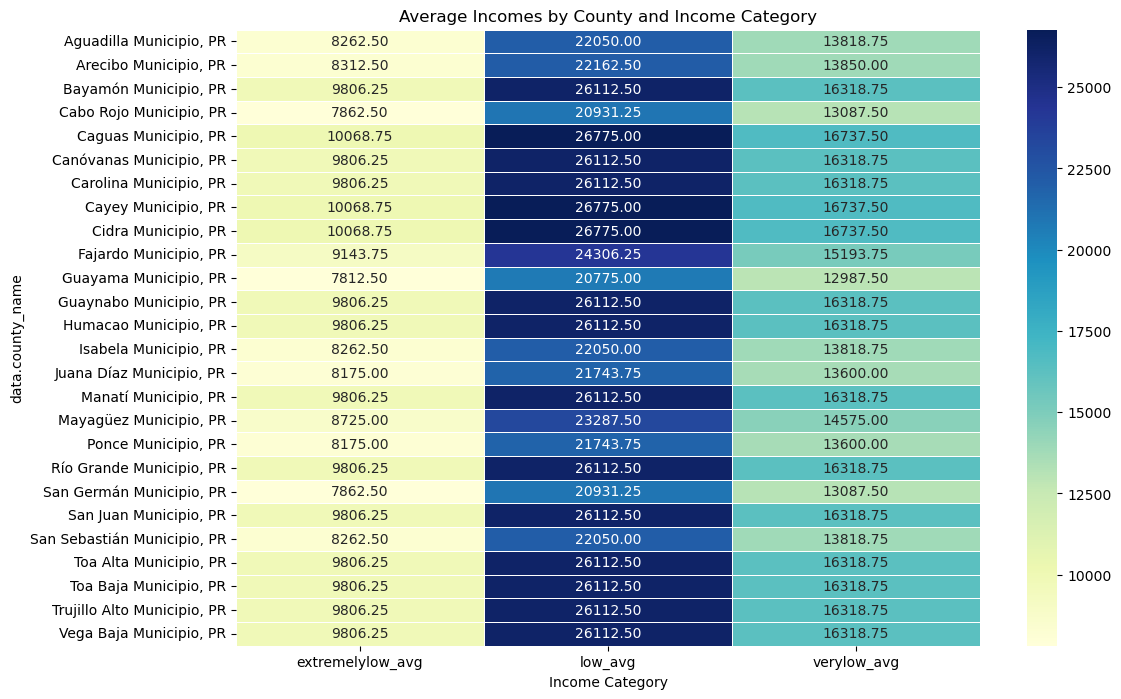

In [187]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Average Incomes by County and Income Category')
plt.show()